<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week10_EOF_partII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from cartopy.crs import EqualEarth, PlateCarree

https://xeofs.readthedocs.io/en/latest/index.html

conda install -c conda-forge xeofs

pip install xeofs

In [13]:
pip install xeofs

Note: you may need to restart the kernel to use updated packages.


In [14]:
from xeofs.xarray import EOF

Read in monthly SST

In [15]:
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
#ds = xr.open_dataset(url)
ds = xr.open_dataset("sst.mnmean.v5.nc")
#url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
#ds = xr.open_dataset(url)

# select period
ds = ds.sel(time=slice('1900', '2022'))

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 1476, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 9.969e+36 9.969e+36 ... 9.969e+36 9.969e+36
    sst        (time, lat, lon) float32 -1.8 -1.8 -1.8 -1.8 ... nan nan nan nan
Attributes: (12/37)
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    ...                        ...
    creator_url_original:      https://www.ncei.noaa.gov
    license:                   No constraints on data access or use
    comment:                   SSTs were observed by conventional thermometer...
    summary:                   ERSST.v5 is developed based on v4 after revisi...
    dataset_title:             NOAA Extended Reconstructed SST V5
    data_modified:             2023-04-04

Make anomalies

In [16]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, time: 1476, nbnds: 2)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1900-01-01 1900-02-01 ... 2022-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sst        (time, lat, lon) float32 2.027e-06 2.027e-06 ... nan nan

Reversed latitudes

In [17]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

Select Tropical Pacific Region

In [18]:
ds_tpac=ds_anoms.sel(lat=slice(-70,70),lon=slice(0,360))

In [19]:
sst = ds_tpac['sst']
coslat = np.cos(np.deg2rad(sst.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
sst=sst*wgts

EOF analysis

In [20]:
#smode
model = EOF(sst, n_modes=5, norm=False, dim='time')
model.solve()
expvar = model.explained_variance_ratio()
eofs = model.eofs()
pcs = model.pcs()

In [21]:
expvar * 100

<xarray.DataArray 'explained_variance_ratio' (mode: 5)>
array([23.67964686, 11.43734129,  3.29469632,  3.02204341,  2.66098775])
Coordinates:
  * mode     (mode) int64 1 2 3 4 5

Create figure showing the first three modes

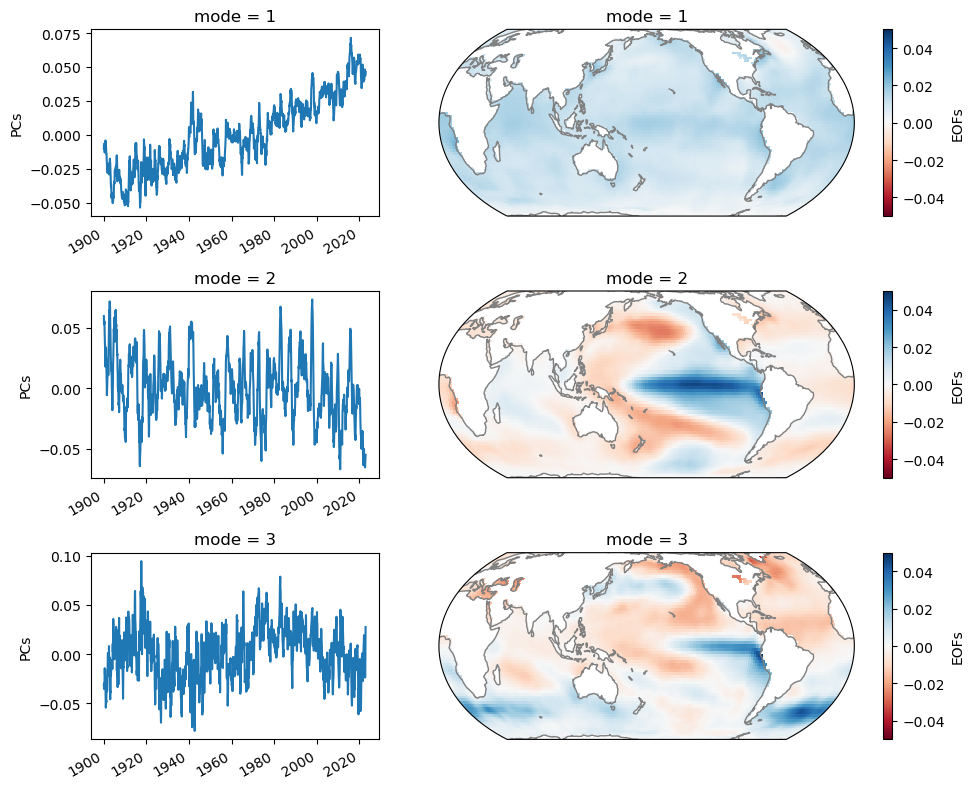

In [22]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'cmap' : 'RdBu', 'vmin' : -.05, 'vmax': .05, 'transform': PlateCarree()
}

fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 2, width_ratios=[1, 2])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(3)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(3)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    pcs.sel(mode=i+1).plot(ax=a0)
    a1.coastlines(color='.5')
    eofs.sel(mode=i+1).plot(ax=a1, **kwargs)

    a0.set_xlabel('')

plt.tight_layout()
plt.savefig('eof-smode.jpg')